In [87]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})
from hsl_functions import *
import glob
from scipy.signal import medfilt,butter
import corner
import scipy

In [88]:
# Book-keeping Functions
n_splits = 10

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [89]:
df = p.load(open('df.p','rb'))

all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

## IBI Functions

In [90]:
def ibi_iqr(signal):
    return scipy.stats.iqr(signal)

def ibi_std(signal):
    return np.std(signal)

def rmssd(signal):
    return np.sqrt(np.mean(np.square(np.diff(signal))))

def ibi_passbands(signal):
    fs,pxx = scipy.signal.periodogram(signal, nfft = 1000, scaling = 'density', detrend = 'constant')

    vlfband = (fs > 0.0033)*(fs < 0.04)
    lfband = (fs > 0.04)*(fs < 0.15)
    hfband = (fs > 0.15) * (fs < 0.4)

    vlf_integral = np.trapz(pxx[vlfband],fs[vlfband]) #unsure what this does
    lf_integral = np.trapz(pxx[lfband],fs[lfband])
    hf_integral = np.trapz(pxx[hfband],fs[hfband])

    return [vlf_integral,lf_integral,hf_integral]

def ibi_lfhf(signal):
    return ibi_passbands(signal)[1]/ibi_passbands(signal)[2]

In [91]:
def ibi_features(signal):
    functions = [ibi_iqr, ibi_std, rmssd, ibi_lfhf]
    measure_names = ['ibi_iqr', 'ibi_std', 'ibi_rmssd', 'ibi_lf/hf']
    features = np.asarray([func(signal) for func in functions]).reshape(-1,1)
    fdf = pd.DataFrame(columns = measure_names, data = features.T)
    return fdf

In [92]:
signal = get_signal('IBI', 2, 23)

In [93]:
feat = ibi_features(signal)

## EDA Functions

In [94]:
def eda_median(signal):
    return np.median(signal)

def mean_firstdiff(signal):
    return np.mean(np.abs(np.diff(signal, n=1)))

def std_firstdiff(signal):
    return np.std(np.abs(np.diff(signal, n=1)))

def mean_seconddiff(signal):
    return np.mean(np.abs(np.diff(signal, n=2)))

def std_seconddiff(signal):
    return np.std(np.abs(np.diff(signal, n=2)))

def find_peaks(signal):
    #normalize function
    norm_signal = medfilt((signal-np.mean(signal))/np.std(signal), 31)
    #find peaks
    peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/12, prominence = 0.25)
    if len(peaks) == 0:
        peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/14, prominence = 0.1)
    if len(peaks) == 0:
        peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/14)
    min_0 = np.argmin(signal[0:peaks[0]])
    min_peaks = [min_0]
    for i in range(1,len(peaks)):
        min_i = np.argmin(signal[peaks[i-1]:peaks[i]])
        min_peaks.append((peaks[i-1]+min_i))
    return peaks, min_peaks

def orienting_features(signal):
    peaks, onsets = find_peaks(signal)
    num_onsets = len(onsets)
    sum_peaks = sum(signal[peaks])
    sum_onsets = sum(signal[onsets])
    sum_difference = sum_peaks - sum_onsets
    
    orienting_duration = []
    for i in range(len(peaks)):
        orienting_duration.append(peaks[i]-onsets[i])
    mean_od = np.mean(orienting_duration)
    sum_od = sum(orienting_duration)
    
    areas = []
    for i in range(len(peaks)):
        areas.append(0.5*orienting_duration[i]*peaks[i])
    
    sum_areas = sum(areas)
    
    mean_amplitude = []
    for i in range(len(peaks)):
        mean_amplitude.append((peaks[i]+onsets[i])/2)
    
    mean_amp = np.mean(mean_amplitude)
    total_amp = sum(mean_amplitude)
    return [num_onsets, sum_onsets, sum_peaks, sum_difference, sum_areas, sum_od, mean_od, mean_amp, total_amp]

def EDA_passbands(signal):
    fs,pxx = scipy.signal.periodogram(signal, nfft = 1000, scaling = 'density', detrend = 'linear')
    # plt.figure()
    # plt.plot(fs,pxx)
    # plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')

    vlfband = (fs > 0.001)*(fs < 0.045)
    lfband = (fs > 0.045)*(fs < 0.15)
    hfband = (fs > 0.15) * (fs < 0.25)

    # plt.figure(figsize = (13,7))
    # plt.plot(fs,pxx,'k')
    # #plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')
    # plt.plot(fs,vlfband*np.max(pxx),label = 'VLF')
    # plt.plot(fs,lfband*np.max(pxx),label = 'LF')
    # plt.plot(fs,hfband*np.max(pxx),label = 'HF')
    # plt.title('IBI Frequency Passbands')
    # plt.legend()

    vlf_integral = np.trapz(pxx[vlfband],fs[vlfband])
    lf_integral = np.trapz(pxx[lfband],fs[lfband])
    hf_integral = np.trapz(pxx[hfband],fs[hfband])

    return [vlf_integral,lf_integral,hf_integral]

def eda_lfhf(signal):
    return EDA_passbands(signal)[1]/EDA_passbands(signal)[2]

def eda_features(signal):
    functions = [eda_median, mean_firstdiff, std_firstdiff, mean_seconddiff, std_seconddiff, eda_lfhf]
    measure_names = ['eda_median', 'eda_mean1diff', 'eda_std1diff', 'eda_mean2diff', 'eda_std2diff', 'eda_lf/hf']
    features = np.asarray([func(signal) for func in functions]).reshape(-1,1)
    fdf = pd.DataFrame(columns = measure_names, data = features.T)
    
    orient_features = np.asarray(orienting_features(signal)).reshape(-1,1)
    orient_featurenames = ['eda_num_onsets', 'eda_sum_onsets', 'eda_sum_peaks', 'eda_sum_difference',\
                           'eda_sum_areas', 'eda_sum_od', 'eda_mean_od', 'eda_mean_amp', 'eda_total_amp']
    ofdf = pd.DataFrame(columns = orient_featurenames, data = orient_features.T)
    
    return fdf.join(ofdf)

## Shimmer Functions

In [117]:
shimfiles = glob.glob('shimmerData/*/*')

def get_shimmer(subjno, part, epochno):
    epoch = num_to_epoch(epochno)
    if epoch == 'REC':
        epoch = 'Rec'
    elif epoch == 'P1':
        epoch = '_P1'
    elif epoch == 'P2':
        epoch = '_P2'
    
    for file in shimfiles:
        if str(subjno) in file and part in file and epoch in file:
            data = pd.read_csv(file, header = None)
    try:
        vectors = np.asarray(data[[1,2,3]])
    except:
        print('mising shimmer data. skipping...')
        return np.repeat(np.nan, 1000)
    mean = np.mean(vectors, axis = 0)
    std = np.std(vectors, axis = 0)
    
    vectors = (vectors - mean[np.newaxis,:])

    #plt.plot(vectors)
    
    z_vector = np.linalg.norm(vectors, axis = 1)

    return z_vector

def get_split_shimmer(subjno, part, epochno, splitno):

    z_vector = get_shimmer(subjno,part,epochno)

    return np.array_split(z_vector,n_splits)[splitno]

def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    dfa_exp = dfa(signal)
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, dfa_exp])

def spectrum_statistics(signal):
    
    fs,pxx = scipy.signal.periodogram(signal, fs = 50, nfft = 1000, scaling = 'density', detrend = 'constant')
    
#     plt.plot(fs,pxx)
    #plt.xlim(0,0.1)

    peak = fs[np.argmax(pxx)]
    peakmag = np.max(pxx)
    integral = np.trapz(pxx,fs)
    energy = np.dot(pxx,pxx)
    shannon = np.sum(pxx*np.log(1/pxx))

    # Add wavelet analysis

    return [peak, peakmag, integral, energy, shannon]

def bodyshimmer_features(signal):
    shim_stats = signal_statistics(signal).reshape(-1,1)
    stat_names = ['bodyshim_mean', 'bodyshim_std', 'bodyshim_skewness', 'bodyshim_kurtosis', \
'bodyshim_maximum', 'bodyshim_minimum', 'bodyshim_iqr', 'bodyshim_variation', 'bodyshim_entropy', 'bodyshim_dfa']
    fdf = pd.DataFrame(columns = stat_names, data = shim_stats.T)
    
    spec_stats = np.asarray(spectrum_statistics(signal)).reshape(-1,1)
    specstat_names = ['bodyshim_peakfreq','bodyshim_peakpower','bodyshim_powerint','bodyshim_specenergy',\
                   'bodyshim_shannon']
    spec_fdf = pd.DataFrame(columns = specstat_names, data = spec_stats.T)
    
    return fdf.join(spec_fdf)

def headshimmer_features(signal):
    shim_stats = signal_statistics(signal).reshape(-1,1)
    stat_names = ['headshim_mean', 'headshim_std', 'headshim_skewness', 'headshim_kurtosis', \
'headshim_maximum', 'headshim_minimum', 'headshim_iqr', 'headshim_variation', 'headshim_entropy', 'headshim_dfa']
    fdf = pd.DataFrame(columns = stat_names, data = shim_stats.T)
    
    spec_stats = np.asarray(spectrum_statistics(signal)).reshape(-1,1)
    specstat_names = ['headshim_peakfreq','headshim_peakpower','headshim_powerint','headshim_specenergy',\
                   'headshim_shannon']
    spec_fdf = pd.DataFrame(columns = specstat_names, data = spec_stats.T)
    
    return fdf.join(spec_fdf)

## Compute Features

In [126]:
n_splits = 1

fdf = pd.DataFrame()
targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            ibi_signal = get_split_signal('IBI', epoch, subjno, splitno)
            ibi_df = ibi_features(ibi_signal)
            
            eda_signal = get_split_signal('EDA', epoch, subjno, splitno)
            eda_df = eda_features(eda_signal)
            
            head_shimmer = get_split_shimmer(subjno, 'head', epoch, splitno)
            head_df = headshimmer_features(head_shimmer)
            
            body_shimmer = get_split_shimmer(subjno, 'body', epoch, splitno)
            body_df = bodyshimmer_features(body_shimmer)
            
            fdf = pd.concat([fdf, ibi_df.join(eda_df).join(head_df).join(body_df)])
            targets.append(is_perturbed(epoch))

  6%|▌         | 2/33 [00:34<09:02, 17.48s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


  9%|▉         | 3/33 [00:44<07:34, 15.14s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 12%|█▏        | 4/33 [00:53<06:25, 13.28s/it]

mising shimmer data. skipping...


 18%|█▊        | 6/33 [01:28<06:53, 15.32s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 27%|██▋       | 9/33 [01:59<05:21, 13.39s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 30%|███       | 10/33 [02:07<04:35, 11.98s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 82%|████████▏ | 27/33 [07:05<01:55, 19.32s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


100%|██████████| 33/33 [08:43<00:00, 17.60s/it]


In [127]:
notnan = np.sum(np.isnan(fdf),1).values == 0
fdf_clean = fdf[notnan]
targets_clean = np.asarray(targets)[notnan]

## Logistic Regression

In [211]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

In [184]:
X = np.asarray(fdf_clean)
t = np.asarray(targets_clean)

sc = preprocessing.MinMaxScaler()
X_scaled = sc.fit_transform(X)

In [185]:
scores = mutual_info_classif(X_scaled,t)

Text(0.5, 1.0, 'Mutual Information Feature Selection')

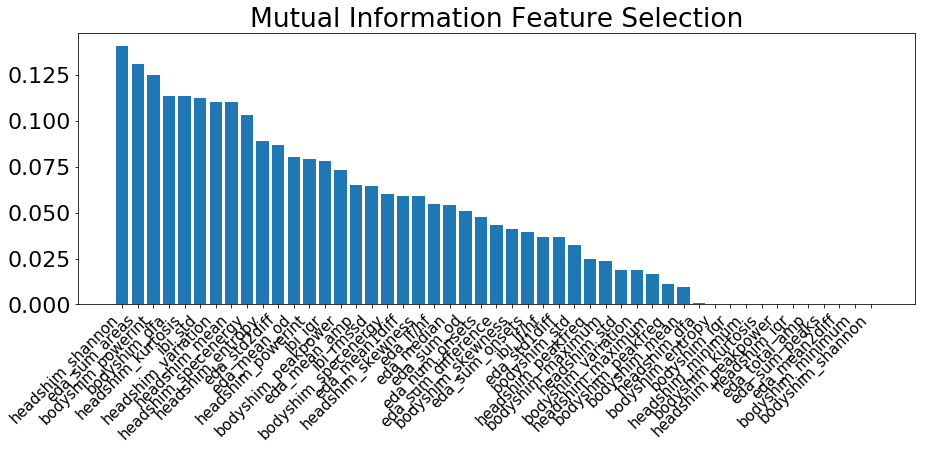

In [186]:
plt.figure(figsize=(15,5))
sortidx = np.argsort(-scores)
plt.bar(fdf.columns[sortidx],height=scores[sortidx],)
plt.xticks(rotation=45, ha='right',fontsize=15);
plt.title('Mutual Information Feature Selection')

0.9564471879286695


Text(0.5, 0.1, 'AUC = 0.96')

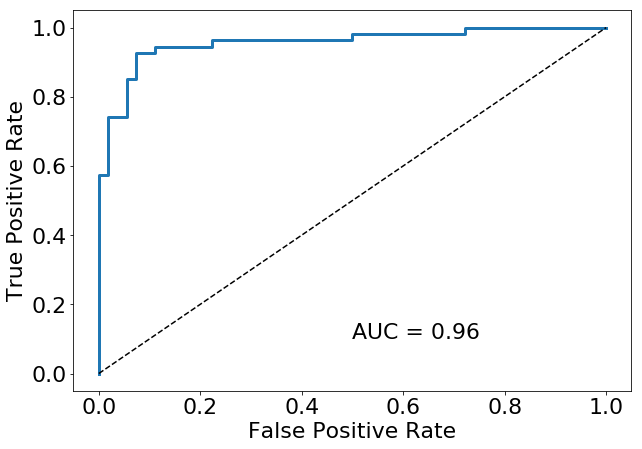

In [198]:
clf = linear_model.LogisticRegression(solver = 'newton-cg', max_iter = 1000000, tol = 0.000001)

clf.fit(X_scaled,t)

lr_fpr,lr_tpr,_ = roc_curve(t,clf.predict_proba(X_scaled)[:,1])
print(auc(lr_fpr,lr_tpr))
plt.figure(figsize = (10,7))
plt.plot(lr_fpr,lr_tpr, linewidth = 3)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.5,0.1, 'AUC = %.2f'%auc(lr_fpr, lr_tpr))

Text(0.3, 0.6, 'F-1 Score = 0.91')

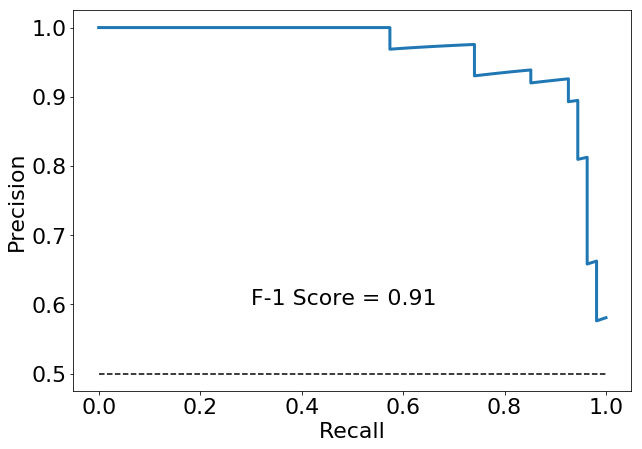

In [218]:
precision, recall, thresholds = precision_recall_curve(t,clf.predict_proba(X_scaled)[:,1])
f1 = f1_score(t,clf.predict(X_scaled))
plt.figure(figsize = (10,7))
plt.plot(recall, precision, linewidth = 3)
plt.plot(x, np.repeat(0.5, len(x)), 'k--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.text(0.3,0.6, 'F-1 Score = %.2f'%f1)

Text(0, 0.5, 'EDA Sum of Peak Areas')

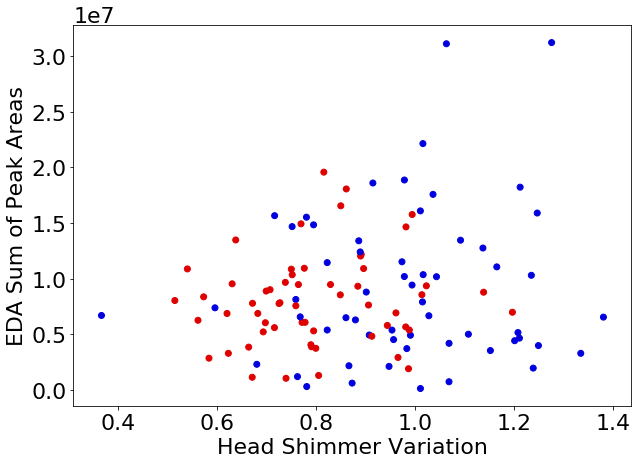

In [175]:
plt.figure(figsize = (10,7))
plt.scatter(fdf['headshim_variation'], fdf['eda_sum_areas'], c = targets, cmap = 'jet', vmin = -0.1, vmax = 1.1)
plt.xlabel('Head Shimmer Variation')
plt.ylabel('EDA Sum of Peak Areas')

Text(0, 0.5, 'EDA 2nd Diff Std')

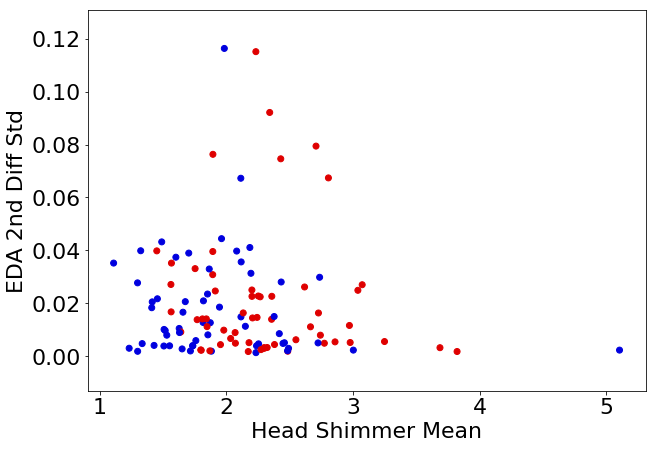

In [176]:
plt.figure(figsize = (10,7))
plt.scatter(fdf['headshim_mean'], fdf['eda_std2diff'], c = targets, cmap = 'jet', vmin = -0.1, vmax = 1.1)
plt.xlabel('Head Shimmer Mean')
plt.ylabel('EDA 2nd Diff Std')

(0, 0.3)

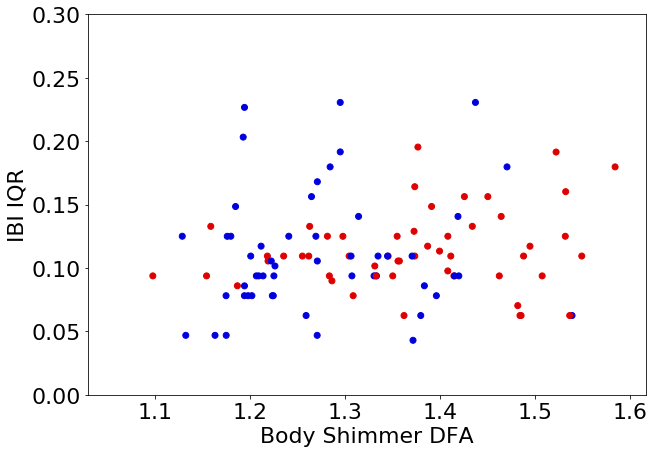

In [179]:
plt.figure(figsize = (10,7))
plt.scatter(fdf['bodyshim_dfa'], fdf['ibi_iqr'], c = targets,cmap = 'jet', vmin = -0.1, vmax = 1.1)
plt.xlabel('Body Shimmer DFA')
plt.ylabel('IBI IQR')
plt.ylim(0,.3)